In [2]:
import numpy as np
import pandas as pd
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
rng = np.random.default_rng(42)
df = pd.read_csv('datasets/uncontrollable_sample.csv', index_col = 'id')

## Building a baseline SVM model using all "uncontrollable" features

Split and normalize data:

In [4]:
X_train0, X_test0, Y_train0, Y_test0 = train_test_split(df.drop('Label', 1), df.Label, test_size = 0.2, random_state = 42)

scaler = StandardScaler().fit(X_train0)
X_train_scaled0 = pd.DataFrame(scaler.transform(X_train0), columns = df.drop('Label', 1).columns)
X_test_scaled0 = pd.DataFrame(scaler.transform(X_test0), columns = df.drop('Label', 1).columns)

Baseline model using linear kernel:

In [16]:
svm_base = svm.SVC(kernel = 'linear')
svm_base.fit(X_train_scaled0, Y_train0)
Y_pred0 = svm_base.decision_function(X_test_scaled0)

fpr_svm0, tpr_svm0, thresholds_svm0 = metrics.roc_curve(Y_test0, Y_pred0)
auc_svm0 = metrics.auc(fpr_svm0, tpr_svm0)
#acc_svm0 = np.mean(np.abs(Y_test0 - Y_pred0))

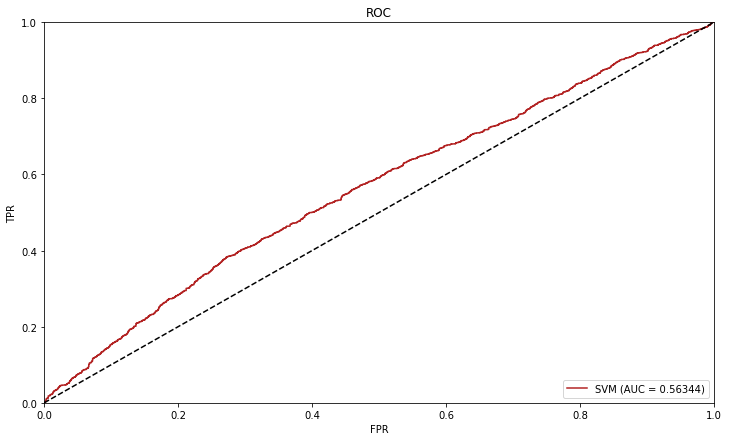

In [18]:
fig = plt.figure(figsize = (12,7))

plt.plot(fpr_svm0, tpr_svm0, color = "firebrick", label = "SVM (AUC = {:0.5f})".format(auc_svm0))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc = 'lower right')

plt.show()

In [19]:
print("Baseline model accuracy = {:.5f}".format(acc_svm0))

Baseline model accuracy = 0.95417


### Hyperparameter selection (i)

In [20]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters over which to search
param_grid = [
    {'C': np.logspace(-5,2, num = 1000), 
     'kernel': ['linear', 'rbf', 'sigmoid', 'poly']}
]

scores = ['roc_auc', 'accuracy']

clf_RS = RandomizedSearchCV(svm.SVC(), param_distributions = param_grid, scoring = scores, cv = 5, refit = scores[0],
                           n_jobs = -1)
clf_RS.fit(X_train_scaled0, Y_train0)

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions=[{'C': array([1.00000000e-05, 1.01626509e-05, 1.03279473e-05, 1.04959323e-05,
       1.06666496e-05, 1.08401436e-05, 1.10164595e-05, 1.11956432e-05,
       1.13777413e-05, 1.15628013e-05, 1.17508713e-05, 1.19420003e-05,
       1.21362380e-05, 1.23336350e-05, 1.25342427e-05, 1.27381132e-05,
       1.29452998e-05, 1.31558562e-...
       7.35981448e+01, 7.47952252e+01, 7.60117762e+01, 7.72481145e+01,
       7.85045620e+01, 7.97814457e+01, 8.10790981e+01, 8.23978568e+01,
       8.37380654e+01, 8.51000725e+01, 8.64842328e+01, 8.78909065e+01,
       8.93204600e+01, 9.07732653e+01, 9.22497005e+01, 9.37501502e+01,
       9.52750047e+01, 9.68246612e+01, 9.83995230e+01, 1.00000000e+02]),
                                         'kernel': ['linear', 'rbf', 'sigmoid',
                                                    'poly']}],
                   refit='roc_auc', scoring=['roc_auc', 'accuracy'])

In [21]:
clf_RS.best_params_

{'kernel': 'rbf', 'C': 0.2681812609453013}

In [23]:
print("AUC of best-performing model = {:.5f}".format(clf_RS.best_score_))

AUC of best-performing model = 0.56586


## Feature selection

In [8]:
df_filtered = df[['idpop_local_sum', 'idpop_citywide_sum', 'idpop_local_food_sum',
       'idpop_citywide_food_sum', 'idpop_local_nightlife_sum',
       'idpop_citywide_nightlife_sum', 'idpop_local_travel_sum',
       'idpop_citywide_travel_sum', 'venue_count_500m', 'sub_cnt_20m',
       'sub__line_cnt_20m', 'comp', 'comp_hotel',
       'Demo % - ACS 2011 Means of transportation: Public transportation - Subway - Zipcode',
       'Demo % - Age - Age 00 - 14 - Zipcode - ACS 2011',
       'Demo % - Age - Age 15 - 29 - Zipcode - ACS 2011',
       'Demo % - Age - Age 30 - 44 - Zipcode - ACS 2011',
       'Demo % - Age - Age 45 - 59 - Zipcode - ACS 2011',
       'Demo % - Age - Age 60 + - Zipcode - ACS 2011',
       'Demo % - Education - Pop 25 yrs + Bachelors Degree - Zipcode - ACS 2011',
       'Demo % - Education - Pop 25 yrs + Masters degree - Zipcode - ACS 2011',
       'Demo % - Ethnicity - Non-White Population - Zipcode - ACS 2011',
       'Demo % - Households - Household Size: 1-2 Persons - Zipcode - ACS 2011',
       'Demo % - Households - Household Size: 3+ Persons - Zipcode - ACS 2011',
       'Demo % - Households - Household Size: 7 + Persons - Zipcode - ACS 2011',
       'Demo % - Income - Hhld Income $100,000 + % - Zipcode - ACS 2011',
       'Demo % - Population - Female Population - Zipcode - ACS 2011',
       'Demo % - Population - Male Population - Zipcode - ACS 2011',
       'Demo - Age - Median Age Total Population - Zipcode - ACS 2011',
       'Demo - Households - Median Household Income - Zipcode - ACS 2011',
       'Demo - Population Density - Total - Zipcode - ACS 2011', 'Label']]

X_train, X_test, Y_train, Y_test = train_test_split(df_filtered.drop('Label', 1), df_filtered.Label, test_size = 0.2, random_state = 42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = df_filtered.drop('Label', 1).columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = df_filtered.drop('Label', 1).columns)

### Baseline model with feature subset

In [11]:
svm_sub = svm.SVC(kernel = 'linear')
svm_sub.fit(X_train_scaled, Y_train)
Y_pred = svm_sub.decision_function(X_test_scaled)

fpr_svm, tpr_svm, thresholds_lr = metrics.roc_curve(Y_test, Y_pred)
auc_svm = metrics.auc(fpr_svm, tpr_svm)
# acc_svm = np.mean(np.abs(Y_test - Y_pred))

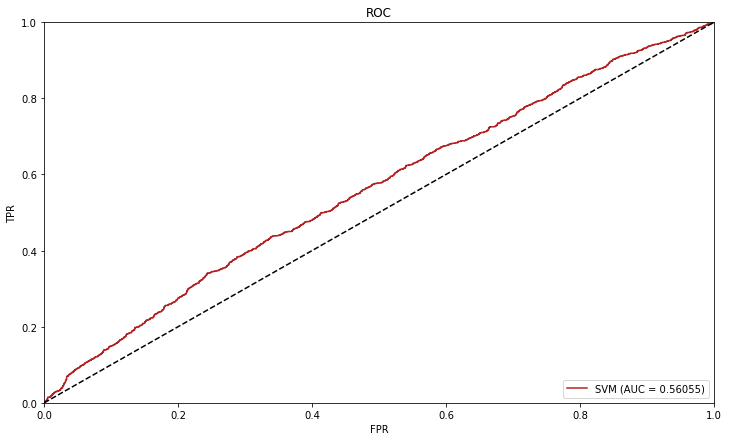

In [13]:
fig = plt.figure(figsize = (12,7))

plt.plot(fpr_svm, tpr_svm, color = "firebrick", label = "SVM (AUC = {:0.5f})".format(auc_svm))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc = 'lower right')

plt.show()

In [14]:
# print("Baseline model accuracy = {:.5f}".format(acc_svm))

Baseline model accuracy = 0.95641


### Hyperparameter selection (ii)

In [24]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters over which to search
param_grid = [
    {'C': np.logspace(-5,2, num = 1000), 
     'kernel': ['linear', 'rbf', 'sigmoid', 'poly']}
]

scores = ['roc_auc', 'accuracy']

clf_RS = RandomizedSearchCV(svm.SVC(), param_distributions = param_grid, scoring = scores, cv = 5, refit = scores[0],
                           n_jobs = -1)
clf_RS.fit(X_train_scaled, Y_train)

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions=[{'C': array([1.00000000e-05, 1.01626509e-05, 1.03279473e-05, 1.04959323e-05,
       1.06666496e-05, 1.08401436e-05, 1.10164595e-05, 1.11956432e-05,
       1.13777413e-05, 1.15628013e-05, 1.17508713e-05, 1.19420003e-05,
       1.21362380e-05, 1.23336350e-05, 1.25342427e-05, 1.27381132e-05,
       1.29452998e-05, 1.31558562e-...
       7.35981448e+01, 7.47952252e+01, 7.60117762e+01, 7.72481145e+01,
       7.85045620e+01, 7.97814457e+01, 8.10790981e+01, 8.23978568e+01,
       8.37380654e+01, 8.51000725e+01, 8.64842328e+01, 8.78909065e+01,
       8.93204600e+01, 9.07732653e+01, 9.22497005e+01, 9.37501502e+01,
       9.52750047e+01, 9.68246612e+01, 9.83995230e+01, 1.00000000e+02]),
                                         'kernel': ['linear', 'rbf', 'sigmoid',
                                                    'poly']}],
                   refit='roc_auc', scoring=['roc_auc', 'accuracy'])

In [25]:
clf_RS.best_params_

{'kernel': 'poly', 'C': 19.92045708453871}

In [26]:
clf_RS.best_score_

0.5679030089527671